In [2]:
# basic
import pandas as pd
import numpy as np

# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# sklearn
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [3]:
df = pd.read_csv('Housing_prices.csv')
df.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             1635 non-null   int64 
 1   area              1635 non-null   int64 
 2   bedrooms          1635 non-null   int64 
 3   bathrooms         1635 non-null   int64 
 4   stories           1635 non-null   int64 
 5   mainroad          1635 non-null   object
 6   guestroom         1635 non-null   object
 7   basement          1635 non-null   object
 8   hotwaterheating   1635 non-null   object
 9   airconditioning   1635 non-null   object
 10  parking           1635 non-null   int64 
 11  prefarea          1635 non-null   object
 12  furnishingstatus  1635 non-null   object
dtypes: int64(6), object(7)
memory usage: 166.2+ KB


No missing values, great!

Let's see how the values are distributed for string columns:

In [7]:
str_col = df.columns[df.dtypes == 'object']
for col in str_col:
   print(df[col].value_counts()/df[col].count())

mainroad
yes    0.858716
no     0.141284
Name: count, dtype: float64
guestroom
no     0.822018
yes    0.177982
Name: count, dtype: float64
basement
no     0.649541
yes    0.350459
Name: count, dtype: float64
hotwaterheating
no     0.954128
yes    0.045872
Name: count, dtype: float64
airconditioning
no     0.684404
yes    0.315596
Name: count, dtype: float64
prefarea
no     0.765138
yes    0.234862
Name: count, dtype: float64
furnishingstatus
semi-furnished    0.416514
unfurnished       0.326606
furnished         0.256881
Name: count, dtype: float64


Now for the numerical columns:

In [8]:
df.describe().T

count          mean           std        min        25%  \
price      1635.0  4.766729e+06  1.869295e+06  1750000.0  3430000.0   
area       1635.0  5.150541e+03  2.168813e+03     1650.0     3600.0   
bedrooms   1635.0  2.965138e+00  7.376120e-01        1.0        2.0   
bathrooms  1635.0  1.286239e+00  5.021620e-01        1.0        1.0   
stories    1635.0  1.805505e+00  8.669614e-01        1.0        1.0   
parking    1635.0  6.935780e-01  8.610583e-01        0.0        0.0   

                 50%        75%         max  
price      4340000.0  5740000.0  13300000.0  
area          4600.0     6360.0     16200.0  
bedrooms         3.0        3.0         6.0  
bathrooms        1.0        2.0         4.0  
stories          2.0        2.0         4.0  
parking          0.0        1.0         3.0

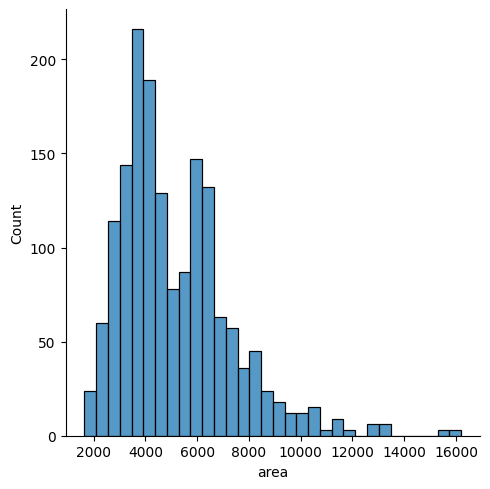

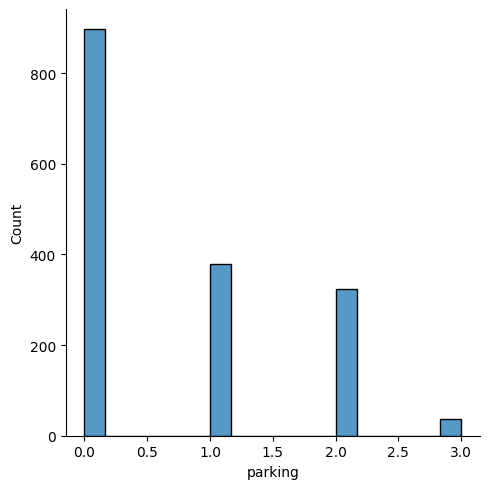

In [9]:
numeric = df.columns[df.dtypes == 'int64']
for col in numeric:
    sns.displot(df[col])

In [10]:
global_mean = df.price.mean()
round(global_mean, 3)

4766729.248

In [239]:
for col in str_col:
    df_group = df.groupby(by=col).price.agg(['mean'])
    df_group['diff'] = round(df_group['mean'] - global_mean,3)
    df_group['risk'] = round(df_group['mean'] / global_mean,3)
    display(df_group)

mean         diff   risk
mainroad                                  
no        3.398905e+06 -1367824.702  0.713
yes       4.991777e+06   225048.081  1.047

mean         diff   risk
guestroom                                  
no         4.544546e+06  -222183.623  0.953
yes        5.792897e+06  1026167.660  1.215

mean        diff   risk
basement                                 
no        4.509966e+06 -256763.316  0.946
yes       5.242615e+06  475885.936  1.100

mean        diff   risk
hotwaterheating                                 
no               4.728593e+06  -38136.094  0.992
yes              5.559960e+06  793230.752  1.166

mean         diff   risk
airconditioning                                  
no               4.191940e+06  -574789.569  0.879
yes              6.013221e+06  1246491.334  1.261

mean         diff   risk
prefarea                                  
no        4.425299e+06  -341430.471  0.928
yes       5.879046e+06  1112316.455  1.233

mean        diff   risk
furnishingstatus                                 
furnished         5.495696e+06  728966.752  1.153
semi-furnished    4.907524e+06  140794.981  1.030
unfurnished       4.013831e+06 -752897.787  0.842

Encoding

In [11]:
df = df.replace({'yes': 1, 'no': 0})
cat = df.iloc[:,1:].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(cat)
X_dict = dv.transform(cat)
X_dict

array([[1.00e+00, 7.42e+03, 0.00e+00, ..., 2.00e+00, 1.00e+00, 3.00e+00],
       [1.00e+00, 8.96e+03, 0.00e+00, ..., 3.00e+00, 0.00e+00, 4.00e+00],
       [0.00e+00, 9.96e+03, 1.00e+00, ..., 2.00e+00, 1.00e+00, 2.00e+00],
       ...,
       [0.00e+00, 3.62e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [0.00e+00, 2.91e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [0.00e+00, 3.85e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 2.00e+00]])

In [12]:
dv.get_feature_names_out()

array(['airconditioning', 'area', 'basement', 'bathrooms', 'bedrooms',
       'furnishingstatus=furnished', 'furnishingstatus=semi-furnished',
       'furnishingstatus=unfurnished', 'guestroom', 'hotwaterheating',
       'mainroad', 'parking', 'prefarea', 'stories'], dtype=object)

In [297]:
df['log_price'] = np.log1p(df.price)
Y = df.log_price

Train test split

In [298]:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X,Y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, Y_train_full, test_size=0.33, random_state=11)

Scaling

In [243]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

Ridge

In [244]:
ridge_alphas = np.random.uniform(0, 10, 30)
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=4)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.alpha_)

0.4383157913867186


In [267]:
y_pred = ridge_cv.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.21928220095658651

Lasso

In [246]:
lasso_cv = LassoCV(cv = 4, random_state=7)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

8.323661003320532e-05

In [268]:
y_pred = lasso_cv.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.2197757560418535

Random Forest

number of trees

In [261]:
all_scores = {}

for depth in [3,8,15]:
    print('depth: %s' % depth)
    scores = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%s -> %.3f' % (i, score))
        scores.append(score)
    
    all_scores[depth] = scores
    print()

depth: 3
10 -> 0.230
20 -> 0.228
30 -> 0.229
40 -> 0.228
50 -> 0.228
60 -> 0.227
70 -> 0.228
80 -> 0.227
90 -> 0.227
100 -> 0.227
110 -> 0.227
120 -> 0.227
130 -> 0.227
140 -> 0.227
150 -> 0.227
160 -> 0.227
170 -> 0.227
180 -> 0.227
190 -> 0.227
200 -> 0.227

depth: 8
10 -> 0.152
20 -> 0.148
30 -> 0.146
40 -> 0.146
50 -> 0.145
60 -> 0.145
70 -> 0.145
80 -> 0.144
90 -> 0.144
100 -> 0.143
110 -> 0.143
120 -> 0.143
130 -> 0.142
140 -> 0.143
150 -> 0.143
160 -> 0.143
170 -> 0.142
180 -> 0.142
190 -> 0.142
200 -> 0.143

depth: 15
10 -> 0.117
20 -> 0.113
30 -> 0.112
40 -> 0.113
50 -> 0.112
60 -> 0.113
70 -> 0.113
80 -> 0.112
90 -> 0.111
100 -> 0.110
110 -> 0.110
120 -> 0.110
130 -> 0.110
140 -> 0.110
150 -> 0.110
160 -> 0.109
170 -> 0.109
180 -> 0.109
190 -> 0.109
200 -> 0.109



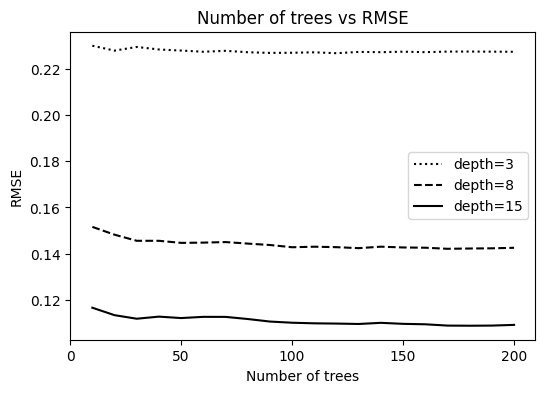

In [262]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_scores[3], label='depth=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_scores[8], label='depth=8', color='black', linestyle='dashed')
plt.plot(num_trees, all_scores[15], label='depth=15', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

min samples leaf

In [264]:
all_scores = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    scores = []

    for i in range(10, 201, 20):
        rf = RandomForestRegressor(n_estimators=i, max_depth=15, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%s -> %.3f' % (i, score))
        scores.append(score)
    
    all_scores[m] = scores
    print()

min_samples_leaf: 3
10 -> 0.117
30 -> 0.112
50 -> 0.112
70 -> 0.113
90 -> 0.111
110 -> 0.110
130 -> 0.110
150 -> 0.110
170 -> 0.109
190 -> 0.109

min_samples_leaf: 5
10 -> 0.117
30 -> 0.112
50 -> 0.112
70 -> 0.113
90 -> 0.111
110 -> 0.110
130 -> 0.110
150 -> 0.110
170 -> 0.109
190 -> 0.109

min_samples_leaf: 10
10 -> 0.117
30 -> 0.112
50 -> 0.112
70 -> 0.113
90 -> 0.111
110 -> 0.110
130 -> 0.110
150 -> 0.110
170 -> 0.109
190 -> 0.109



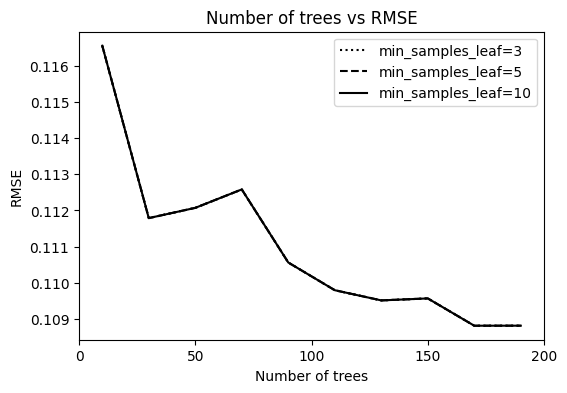

In [265]:

plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 20))

plt.plot(num_trees, all_scores[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_scores[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_scores[10], label='min_samples_leaf=10', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

plt.show()

Final model with best parameters

In [266]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=200,
                      random_state=1)